# **FAKE NEWS CLASSIFIER**
Dataset: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

### **OBJECTIVE**
1. To classify the news from the dataset to fake or true news.
2. Exploratory data analysis of news dataset
3. Selecting and building powerful models for classification. 



### **IMPORT LIBRARIES**

In [12]:
#Basic libraries
import pandas as pd 
import numpy as np 

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Deep learning libraries
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [2]:
import IPython

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

### **IMPORT DATASET**
Lets dive into the dataset.

In [3]:
#reading the fake and true datasets
fake_news = pd.read_csv('/content/drive/MyDrive/PROJECTS/Deep learning/Fake News Classifier/fake and real news/Fake.csv')
true_news = pd.read_csv('/content/drive/MyDrive/PROJECTS/Deep learning/Fake News Classifier/fake and real news/True.csv')

# print shape of fake dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(fake_news.shape))
print (fake_news.info())
print("\n --------------------------------------- \n")

# print shape of true dataset with rows and columns and information
print ("The shape of the  data is (row, column):"+ str(true_news.shape))
print (true_news.info())

The shape of the  data is (row, column):(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

 --------------------------------------- 

The shape of the  data is (row, column):(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


### **DATASET DETAILS**
Dataset contains 23481 fake news and 21417 true news.

Columns are-
1.   title: contains news headlines.
2.   text: contains news content.
3.   subject: type of news.
4.   date: date the news was published.





## **PREPROCESSING AND CLEANING**

### **CREATING THE TARGET COLUMN**

In [4]:
#Target variable for fake news
fake_news['output']=0

#Target variable for true news
true_news['output']=1

### **CONCATENATING TITLE AND TEXT OF NEWS**
News has to be classified based on the tile and text jointly. So, lets concatenate both the columns in both datasets.

In [5]:
#Concatenating and dropping for fake news
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)

#Concatenating and dropping for true news
true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)

#Rearranging the columns
fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

### **CONVERTING THE DATE COLUMNS TO DATETIME FORMAT**
We can use pd.datetime to convert our date columns to date format we desire. But there was a problem,especially in fake_news date column. Let's check the value_counts() to see what lies inside.

In [6]:
fake_news['date'].value_counts()

May 10, 2017                                                                                                                                             46
May 5, 2016                                                                                                                                              44
May 26, 2016                                                                                                                                             44
May 6, 2016                                                                                                                                              44
May 11, 2016                                                                                                                                             43
                                                                                                                                                         ..
November 20, 2017                                               

We had links and news headline inside the date column which can give us trouble when converting to datetime format. So let's remove those records from the column.

In [7]:
#Removing links from the date column
fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]
true_news=true_news[true_news.date.str.contains("Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec")]

#Converting the date to datetime format
fake_news['date'] = pd.to_datetime(fake_news['date'])
true_news['date'] = pd.to_datetime(true_news['date'])

### **APPENDING TWO DATASETS**
When we are providing a dataset for the model, we have to provide it as a single file. So it's better to append both true and fake news data and preprocess it further and perform EDA.

In [8]:
frames = [fake_news, true_news]
news_dataset = pd.concat(frames)
news_dataset

subject  ... output
0           News  ...      0
1           News  ...      0
2           News  ...      0
3           News  ...      0
4           News  ...      0
...          ...  ...    ...
21412  worldnews  ...      1
21413  worldnews  ...      1
21414  worldnews  ...      1
21415  worldnews  ...      1
21416  worldnews  ...      1

[44888 rows x 4 columns]

### **TEXT PROCESSING**
This is an important phase for any text analysis application.There will be many unuseful content in the news which can be an obstacle when feeding to a machine learning model.Unless we remove them the machine learning model doesn't work efficiently. Lets go step by step.

### **NEWS-PUNCTUATION CLEANING**
Remove unnecessary punctuations.

In [9]:
#Creating a copy 
clean_news=news_dataset.copy()

def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
  
clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

subject       date                                               news  output
0    News 2017-12-31   donald trump sends out embarrassing new year’...       0
1    News 2017-12-31   drunk bragging trump staffer started russian ...       0
2    News 2017-12-30   sheriff david clarke becomes an internet joke...       0
3    News 2017-12-29   trump is so obsessed he even has obama’s name...       0
4    News 2017-12-25   pope francis just called out donald trump dur...       0

### **NEWS-STOP WORDS**
A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. We would not want these words to take up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to stop words. NLTK(Natural Language Toolkit) in python has a list of stopwords stored in 16 different languages.


For this project, we are considering the english stop words and removing those words.

In [10]:
nltk.download('stopwords')
stop = stopwords.words('english')
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


subject       date                                               news  output
0    News 2017-12-31  donald trump sends embarrassing new year’s eve...       0
1    News 2017-12-31  drunk bragging trump staffer started russian c...       0
2    News 2017-12-30  sheriff david clarke becomes internet joke thr...       0
3    News 2017-12-29  trump obsessed even obama’s name coded website...       0
4    News 2017-12-25  pope francis called donald trump christmas spe...       0

## **EXPLORATORY DATA ANALYSIS**
We will do exploratory data analysis on news such as ngram analysis and understand which are all the words, context which are most likely found in fake news.

### **COUNT OF NEWS TYPES**

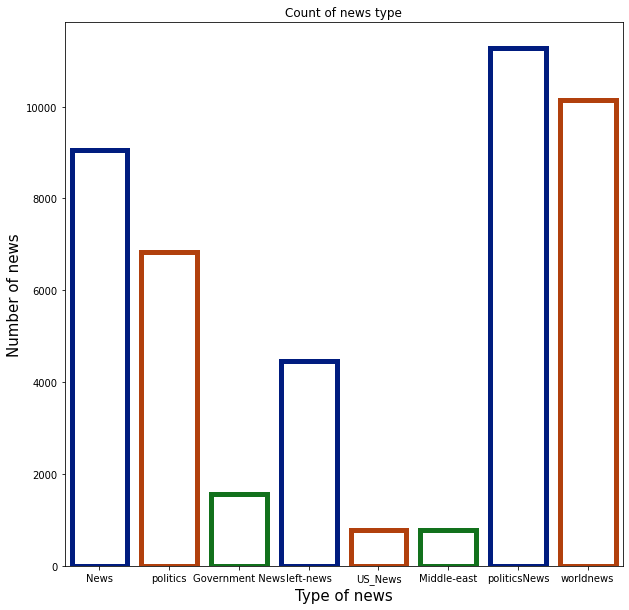

In [13]:
#Plotting the frequency plot
ax = sns.countplot(x="subject", data=clean_news,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))

#Setting labels and font size
ax.set(xlabel='Type of news', ylabel='Number of news',title='Count of news type')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

**Insights**
1. Our dataset has more political news than any other news followed by world
news.
2. We have some repeated class names which expresses same meaning such as news,politics,government news etc which is similar to the alternative.



### **COUNT OF NEWS TYPE BASED ON TRUE OR FAKE**

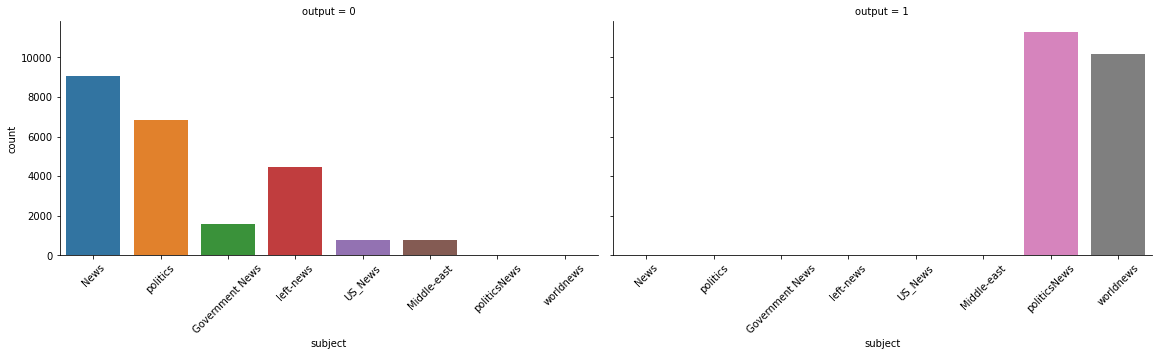

In [14]:
g = sns.catplot(x="subject", col="output",
                data=clean_news, kind="count",
                height=4, aspect=2)

#Rotating the xlabels
g.set_xticklabels(rotation=45)

**Insights**
1. Fake news are all over the category except politics and world news.
2. True news are present only in politics and world news and the count is high.
3. THIS IS A HIGHLY BIASED DATASET and we can expect higher accuracy which doesn't signify it is a good model considering the poor quality of dataset.

### **COUNT OF FAKE NEWS AND TRUE NEWS**


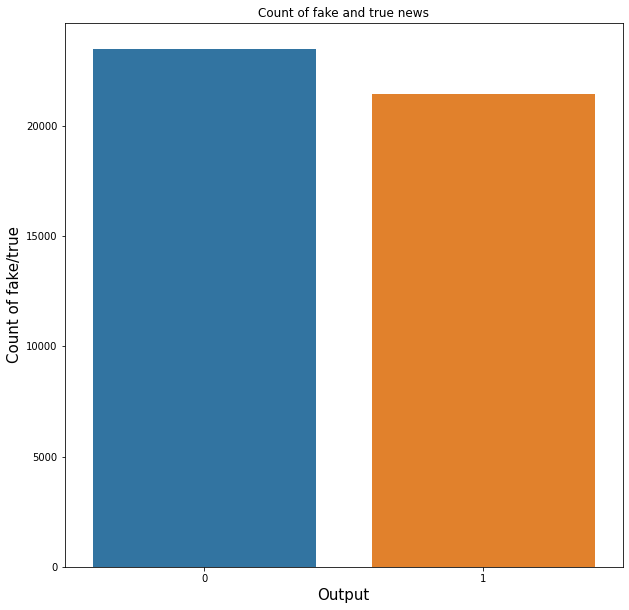

In [15]:
ax=sns.countplot(x="output", data=clean_news)

#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

### **DERIVING NEW FEATURES FROM THE NEWS**
Lets extract more features from the news feature such as

1. Polarity: The measure which signifies the sentiment of th news.
2. Review length: Length of the news(number of letters and spaces).
3. Word Count: Number of words in the news.

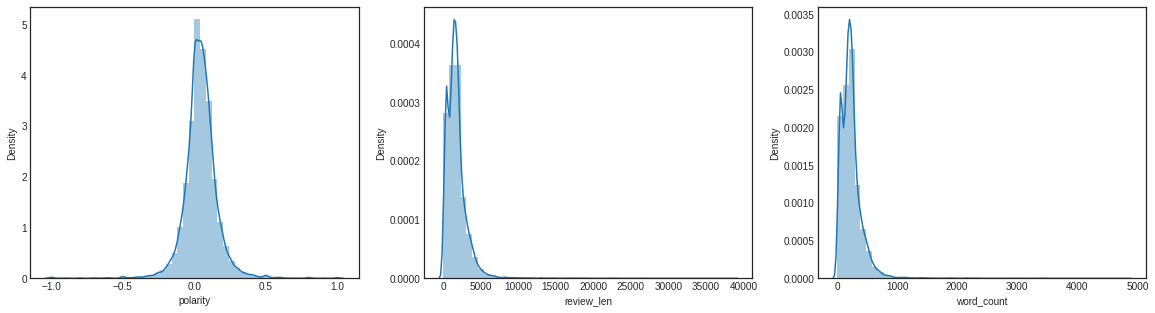

In [16]:
#Extracting the features from the news
clean_news['polarity'] = clean_news['news'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_news['review_len'] = clean_news['news'].astype(str).apply(len)
clean_news['word_count'] = clean_news['news'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(clean_news['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(clean_news['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(clean_news['word_count'])
fig = plt.gcf()

**INSIGHTS**
1. Most of the polarity are neutral, neither it shows some bad news nor much happy news.
2. The word count is between 0-1000 and the length of the news are between 0-5000 and few near 10000 words which could be an article.

## **N-GRAM ANALYSIS**

### **TOP 20 WORDS IN NEWS**

In [17]:
IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

In [18]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(clean_news['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)


#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in news')


trump 140400
said 130258
us 68081
would 55422
president 53189
people 41718
one 36146
state 33190
new 31799
also 31209
obama 29881
clinton 29003
house 28716
government 27392
donald 27376
reuters 27348
states 26331
republican 25287
could 24356
white 23823


### **TOP 20 BIGRAMS**

In [19]:
#Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_bigram(clean_news['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df3 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df3.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in news')

donald trump 25059
united states 18394
white house 15485
hillary clinton 9502
new york 8110
north korea 7053
president donald 6928
image via 6188
barack obama 5603
trump said 4816
prime minister 4753
president trump 4646
supreme court 4595
last year 4560
last week 4512
said statement 4425
fox news 4074
president obama 4065
islamic state 4014
national security 3858


### **TOP 20 TRIGRAMS**

In [20]:
#Function to get top trigram words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_trigram(clean_news['news'], 20)

#Printing word and their respective frequencies
for word, freq in common_words:
    print(word, freq)

#Creating a dataframe with words and count
df6 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Grouping the words and plotting their frequencies
df6.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in news')

president donald trump 6808
president barack obama 3735
new york times 2034
donald trump realdonaldtrump 1790
reuters president donald 1476
black lives matter 1436
president united states 1096
white house said 1050
presidentelect donald trump 1043
new york city 1006
president vladimir putin 955
news century wire 951
national security adviser 898
affordable care act 868
director james comey 860
speaker paul ryan 851
fbi director james 778
state rex tillerson 775
secretary state rex 765
russian president vladimir 745


**INSIGHTS**
1. There is an important news which ruled the US media-'Black lives matter' post the demise of Floyd. We can see that news has been covered in our data. There were lot of fake news revolved around the death.
2. Rest of the news are about US politics.

### **WORDCLOUD OF FALSE NEWS**

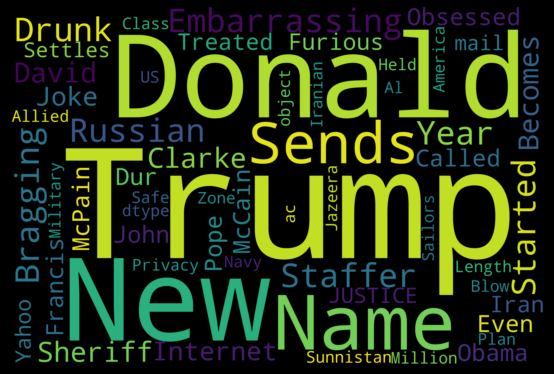

In [21]:
text = fake_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**INSIGHTS**
1. Most of the fake news revolves around Donald Trump.
2. There are also fake news about privacy, internet etc.


### **WORDCLOUD OF TRUE NEWS**

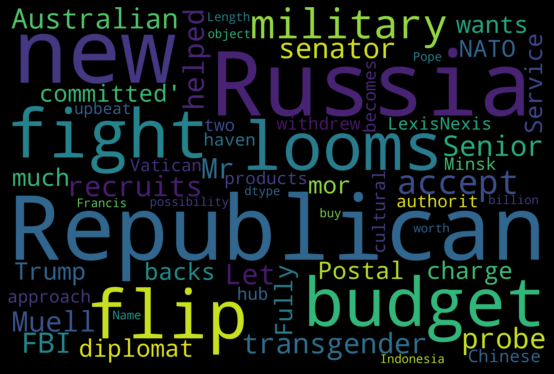

In [22]:
text = true_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (10, 5),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**INSIGHT**
1. True news mostly revolves around Republican Party and Russia.
2. There are news about Budget, military which comes under government news.

### **TIME SERIES ANALYSIS- FAKE/TRUE NEWS**
Let's look at the timeline of true and fake news that were circulated in the media.

In [23]:
#Creating the count of output based on date
fake=fake_news.groupby(['date'])['output'].count()
fake=pd.DataFrame(fake)

true=true_news.groupby(['date'])['output'].count()
true=pd.DataFrame(true)

#Plotting the time series graph
fig = go.Figure()
fig.add_trace(go.Scatter(
         x=true.index,
         y=true['output'],
         name='True',
    line=dict(color='blue'),
    opacity=0.8))

fig.add_trace(go.Scatter(
         x=fake.index,
         y=fake['output'],
         name='Fake',
             line=dict(color='red'),
    opacity=0.8))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.update_layout(title_text='True and Fake News',plot_bgcolor='rgb(248, 248, 255)',yaxis_title='Value')

fig.show()

**INSIGHTS**

1. True news got their dominance since Aug 2017. As they are seen at a very higher rates.That is a good sign
2. There are few outliers in true news where it was higher than the fake news(Nov 9, 2016 and Apr 7, 2017)
3. Our dataset has more fake news than the true one as we can see that we don't have true news data for whole 2015, So the fake news classification will be pretty accurate than the true news getting classified

## **STEMMING AND VECTORIZING**

### **STEMMING THE REVIEWS**
Stemming is a method of deriving root word from the inflected word. Here we extract the reviews and convert the words in reviews to its root word. for example,

Going->go

Finally->fina

If you notice, the root words doesn't need to carry a semantic meaning. There is another technique knows as Lemmatization where it converts the words into root words which has a semantic meaning. Since it takes time, I'm using stemming.

In [24]:
#Extracting 'reviews' for processing
news_features=clean_news.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

news
0  donald trump sends embarrassing new year’s eve...
1  drunk bragging trump staffer started russian c...
2  sheriff david clarke becomes internet joke thr...
3  trump obsessed even obama’s name coded website...
4  pope francis called donald trump christmas spe...

In [25]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news) 

In [26]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

## **MACHINE LEARNING MODEL BUILDING AND SELECTION**

### **TFIDF(Term Frequency — Inverse Document Frequency)**

TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus.

Here we will consider both unigrams and bigrams for calculating TF-IDF and consider top 8000 features based on term frequency.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=8000,ngram_range=(1,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(news_features['news'])
X.shape

(44888, 8000)

In [32]:
#Getting the target variable
y=clean_news['output']

### **CHECKING FOR BALANCE OF DATA**
We should be careful about when handling imbalance data. If it is imbalanced, the model will be biased towards the higher frequency class and returns max output.

In [ ]:
print(f'Original dataset shape : {Counter(y)}')

Original dataset shape : Counter({0: 23471, 1: 21417})


Our dataset is nearly a balanced one. So let's leave balancing it.

### **TRAIN-TEST SPLIT(75:25)**

In [ ]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### **CONFUSION MATRIX FUNCTION**

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### **MODEL SELECTION**
First select the best peforming model by using cross validaton. Let's consider all the classification algorithm and perform the model selection process.

In [ ]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
nb_cv=MultinomialNB(alpha=0.1) 
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,nb_cv]

#Printing the accuracy
for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.9834252643320234
Decision Tree Test Accuracy: 0.9771209152974055
KNN Test Accuracy: 0.8301798881321701
Naive Bayes Test Accuracy: 0.9282885794508979


From the results, we can see logistic regression outdone the rest of the algorithms followed by Decision Tree and Naive Bayes.That's great. So let's go with logistic regression with hyperparameter tuning.

### **LOGISTIC REGRESSION WITH HYPERPARAMETER TUNING**
We use regularization parameter and penality for parameter tuning. Let's see which one to plug.

In [ ]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("Best Penalty:", best_model.best_estimator_.get_params()["penalty"])
print("Best C:", best_model.best_estimator_.get_params()["C"])
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=1048.1131341546852, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Penalty: l2
Best C: 1048.1131341546852
The mean accuracy of the model is: 0.9952771342006772


We will train our model with the best estimate.

In [ ]:
logreg = LogisticRegression(C=best_model.best_estimator_.get_params()["C"], random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


### **CONFUSION MATRIX**

Confusion matrix, without normalization


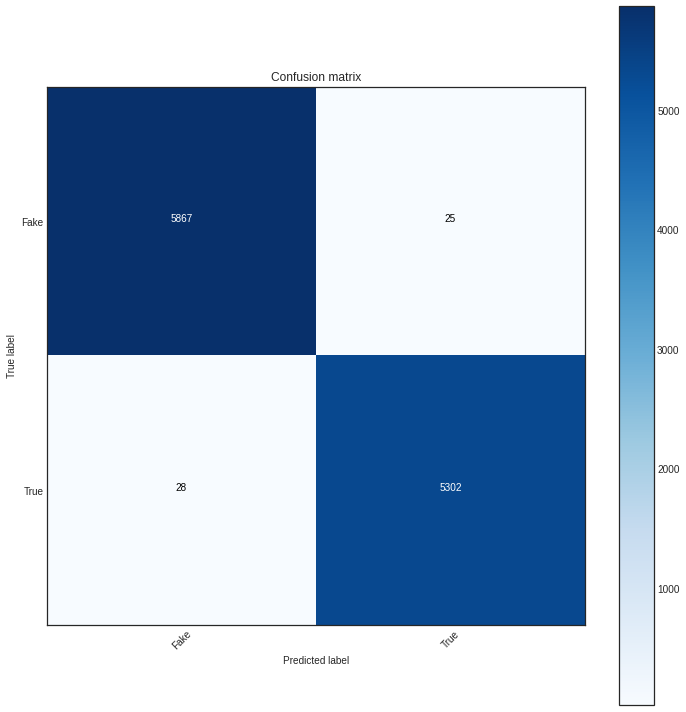

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Fake','True'])

### **CLASSIFICATION REPORT**


In [ ]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5892
           1       1.00      0.99      1.00      5330

    accuracy                           1.00     11222
   macro avg       1.00      1.00      1.00     11222
weighted avg       1.00      1.00      1.00     11222



### **ROC-AUC CURVE**
This is a very important curve where we decide on which threshold to setup based upon the objective criteria.

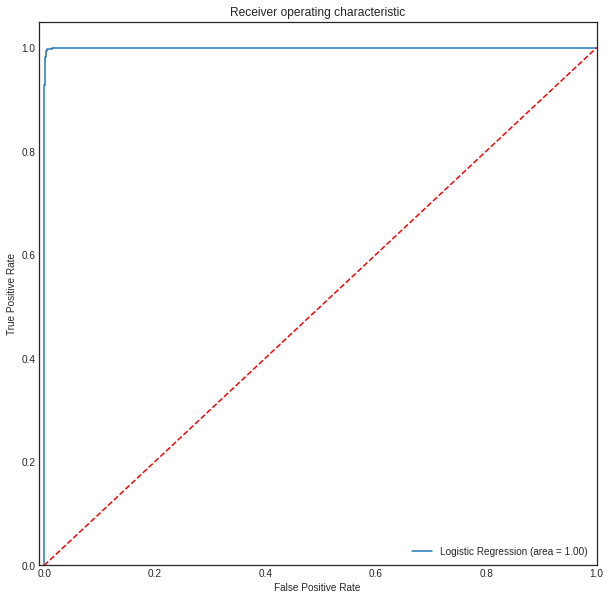

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## **DEEP LEARNING MODEL BUILDING- LSTM AND BIDIRECTIONAL LSTM**
Here in this part we use neural network to predict whether the given news is fake or not.

We aren't gonna use normal neural network like ANN to clasify but LSTM(long short term memory) which helps in containing sequence information.Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more.

### **ONE HOT REPRESENTATION FOR EMBEDDING LAYERS**

In [49]:
#Setting up vocabulary size
voc_size=10000

#One hot encoding 
onehot_repr=[one_hot(words,voc_size)for words in corpus]

We can see all the words in the sentences are transformed into their index from the vocabulary we created.

### **PADDING EMBEDDED DOCUMENTS**
All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our LSTM model, not all the sentences have the same length. In other words, naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the padding is necessary. Here we take the common length as 5000 and perform padding using pad_sequence() function . Also we are going to 'pre' pad so that zeros are added before the sentences to make the sentence of equal length.

In [50]:
#Setting sentence length
sent_length=5000

#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 9612 8406 8494]
 [   0    0    0 ... 5602  694 8494]
 [   0    0    0 ... 9712 7379 8494]
 ...
 [   0    0    0 ... 7246 6306 1637]
 [   0    0    0 ... 3872 7850 4613]
 [   0    0    0 ... 1116 3421 7636]]


In [51]:
embedded_docs[1]

array([   0,    0,    0, ..., 5602,  694, 8494], dtype=int32)

### **LSTM Model**
LSTM Model
At first we are going to develop the base model and compile it. The first layer will be the embedding layer which has the input of vocabulary size, vector features and sentence length. Later we add 30% dropout layer to prevent overfitting and the LSTM layer which has 100 neurons in the layer.In final layer we use sigmoid activation function. Later we compile the model using adam optimizer and binary cross entropy as loss function since we have only two outputs.

To understand how LSTM works please check this link. To give a small overview on how LSTM works,it remembers only the important sequence of words and forgets the insignificant words which doesn't add value in the prediction.

In [30]:
#Creating the lstm model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5000, 40)          400000    
_________________________________________________________________
dropout (Dropout)            (None, 5000, 40)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
len(embedded_docs),y.shape

(44888, (44888,))

### **FITTING THE LSTM MODEL**

In [34]:
# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((44888, 5000), (44888,))

In [35]:
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Fitting with 10 epochs and 64 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
470/470 [==============================] - 141s 284ms/step - loss: 0.3177 - accuracy: 0.8620 - val_loss: 0.0582 - val_accuracy: 0.9822
Epoch 2/10
470/470 [==============================] - 135s 287ms/step - loss: 0.1229 - accuracy: 0.9612 - val_loss: 0.0672 - val_accuracy: 0.9797
Epoch 3/10
470/470 [==============================] - 135s 287ms/step - loss: 0.0570 - accuracy: 0.9810 - val_loss: 0.1174 - val_accuracy: 0.9655
Epoch 4/10
470/470 [==============================] - 136s 288ms/step - loss: 0.0413 - accuracy: 0.9881 - val_loss: 0.0993 - val_accuracy: 0.9677
Epoch 5/10
470/470 [==============================] - 136s 289ms/step - loss: 0.0531 - accuracy: 0.9828 - val_loss: 0.0610 - val_accuracy: 0.9829
Epoch 6/10
470/470 [==============================] - 136s 290ms/step - loss: 0.0247 - accuracy: 0.9926 - val_loss: 0.0436 - val_accuracy: 0.9847
Epoch 7/10
470/470 [==============================] - 136s 290ms/step - loss: 0.1419 - accuracy: 0.9462 - val_loss: 0.1612 -

### **EVALUATION OF LSTM MODEL**

Confusion matrix, without normalization


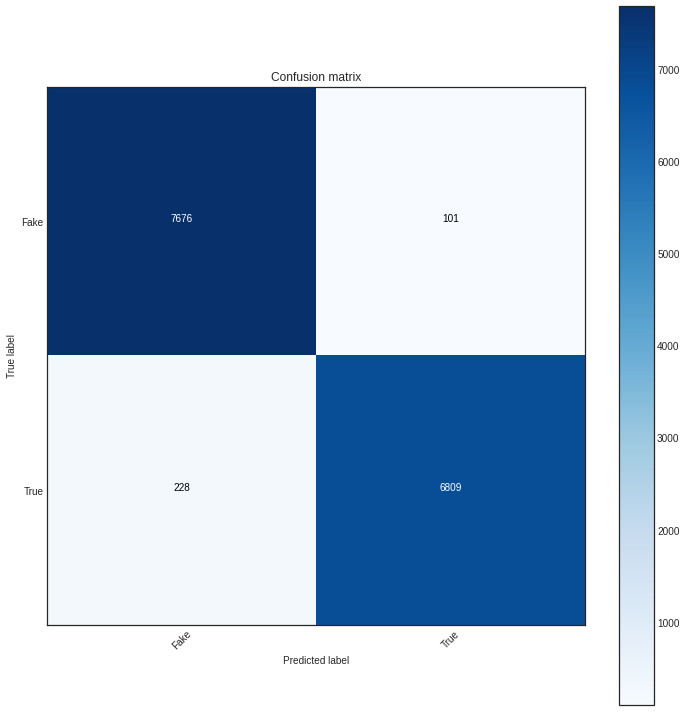

In [38]:
# Predicting from test data
y_pred=model.predict_classes(X_test)

#Creating confusion matrix
#confusion_matrix(y_test,y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,classes=['Fake','True'])

In [39]:
#Checking for accuracy
accuracy_score(y_test,y_pred)

0.9777912785203187

### We have got an accuracy of **97.8%**. That's awesome !




In [40]:
# Creating classification report 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7777
           1       0.99      0.97      0.98      7037

    accuracy                           0.98     14814
   macro avg       0.98      0.98      0.98     14814
weighted avg       0.98      0.98      0.98     14814



From the classification report we can see the accuracy value is nearly around 98%. We have to concentrate on precision score and it is 98% which is great.

### **BIDIRECTIONAL LSTM**
Bi-LSTM is an extension of normal LSTM with two independent RNN's together. The normal LSTM is uni directional where it cannot know the future words whereas in Bi-LSTM we can predict the future use of words as there is a backward information passed on from the other RNN layer in reverse.

In [41]:
# Creating bidirectional lstm model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100))) # Bidirectional LSTM layer
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 40)          400000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 513,001
Trainable params: 513,001
Non-trainable params: 0
_________________________________________________________________
None


### **FITTING AND EVALUATION OF MODEL**


In [52]:
# Fitting the model
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
470/470 [==============================] - 255s 543ms/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.0609 - val_accuracy: 0.9858
Epoch 2/10
470/470 [==============================] - 255s 544ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0487 - val_accuracy: 0.9883
Epoch 3/10
470/470 [==============================] - 255s 542ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0742 - val_accuracy: 0.9808
Epoch 4/10
470/470 [==============================] - 255s 544ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0786 - val_accuracy: 0.9790
Epoch 5/10
470/470 [==============================] - 254s 541ms/step - loss: 0.0042 - accuracy: 0.9986 - val_loss: 0.0812 - val_accuracy: 0.9812
Epoch 6/10
470/470 [==============================] - 254s 542ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0512 - val_accuracy: 0.9885
Epoch 7/10
470/470 [==============================] - 257s 547ms/step - loss: 5.6313e-04 - accuracy: 0.9999 - val_loss: 0.05

Confusion matrix, without normalization


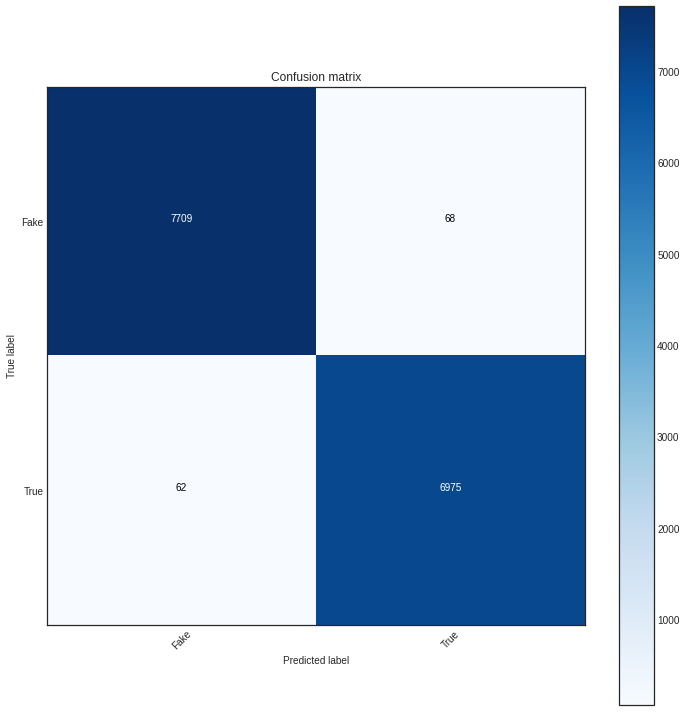

In [53]:
# Predicting from test dataset
y_pred1=model1.predict_classes(X_test)

#Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred1)
plot_confusion_matrix(cm,classes=['Fake','True'])

In [54]:
#Calculating Accuracy score
accuracy_score(y_test,y_pred1)

0.9912245173484542

### We have got an accuracy of **99%**. That's better than LSTM !

In [56]:
# Creating classification report 
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7777
           1       0.99      0.99      0.99      7037

    accuracy                           0.99     14814
   macro avg       0.99      0.99      0.99     14814
weighted avg       0.99      0.99      0.99     14814



From the classification report we can see the accuracy value is nearly around 99%. We have to concentrate on precision score and it is 99%.